# CASO 1 - Toninho vs. Adele

original: mulheres, de Toninho

acusada: Million Years Ago, de Adele


A- MELODIA e HARMONIA

Alegação: A alegação envolvia a melodia principal do refrão e também a
progressão harmônica subjacente

In [1]:
from google.colab import files
import librosa
import librosa.display
import matplotlib.pyplot as plt
import librosa.util
import numpy as np
from scipy.signal import resample
from librosa.sequence import dtw

from librosa.util import normalize
from scipy.spatial.distance import cosine
import warnings
#from dtw import accelerated_dtw

## Carregamento .mp3

In [2]:
print("Faça upload de dois arquivos .mp3 (original e acusado):")
uploaded = files.upload()

file_names = list(uploaded.keys())
if len(file_names) != 2:
    raise ValueError("Você deve carregar exatamente dois arquivos.")


Faça upload de dois arquivos .mp3 (original e acusado):


Saving Million Years Ago.mp3 to Million Years Ago.mp3
Saving Mulheres.mp3 to Mulheres.mp3


In [3]:
print("\nArquivos enviados:")
for i, name in enumerate(file_names):
    print(f"{i+1}: {name}")


print("\nDigite exatamente o nome do arquivo que corresponde à OBRA ORIGINAL:")
nome_original = input().strip()

if nome_original not in file_names:
    raise ValueError("Nome inválido! Certifique-se de digitar exatamente como aparece acima.")


file_original = nome_original
file_acusado = [f for f in file_names if f != nome_original][0]
print(f"\nEntão o acusado é:\n{file_acusado}")


Arquivos enviados:
1: Million Years Ago.mp3
2: Mulheres.mp3

Digite exatamente o nome do arquivo que corresponde à OBRA ORIGINAL:
Mulheres.mp3

Então o acusado é:
Million Years Ago.mp3


# MELODIA

## Cromagramas

In [4]:
# imprimir cromagramas lado a lado

def plot_cromagramas_lado_a_lado(chroma1, chroma2, sr1, sr2, title1, title2, suptitle):
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    fig.suptitle(suptitle, fontsize=16)

    # cromagrama 1
    img1 = librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', sr=sr1, ax=axs[0])
    axs[0].set_title(title1)
    fig.colorbar(img1, ax=axs[0])

    # cromagrama 2
    img2 = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', sr=sr2, ax=axs[1])
    axs[1].set_title(title2)
    fig.colorbar(img2, ax=axs[1])

    # espaço para titulo
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [5]:
y_orig, sr_orig = librosa.load(file_original, sr=None)
y_acus, sr_acus = librosa.load(file_acusado, sr=None)


chroma_orig = librosa.feature.chroma_cqt(y=y_orig, sr=sr_orig)
chroma_acus = librosa.feature.chroma_cqt(y=y_acus, sr=sr_acus)

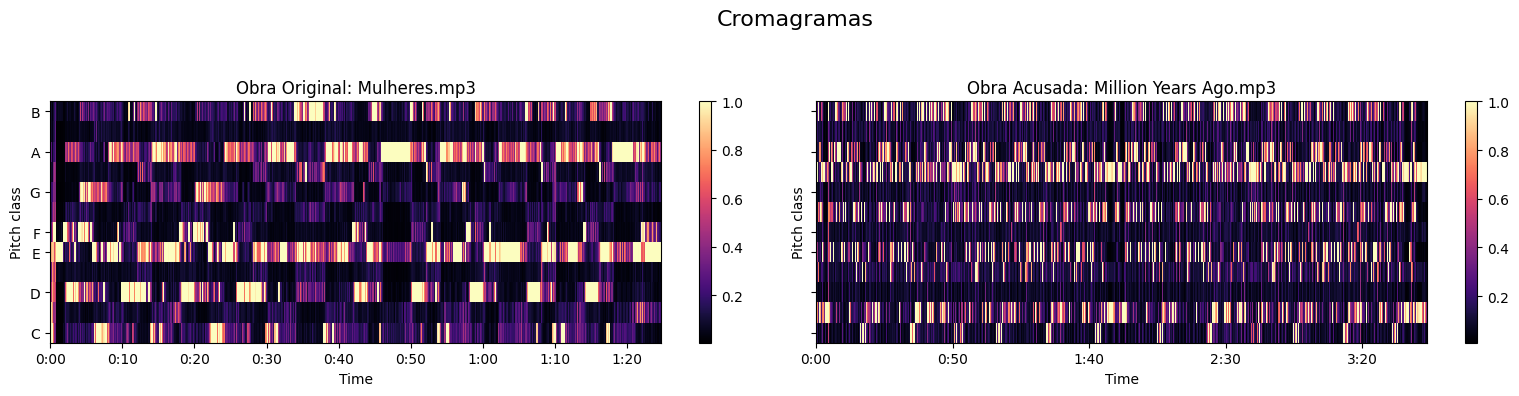

In [6]:
plot_cromagramas_lado_a_lado(
    chroma_orig, chroma_acus,
    sr_orig, sr_acus,
    f'Obra Original: {file_original}',
    f'Obra Acusada: {file_acusado}',
    'Cromagramas'
)

## Cromagramas Normalizados

In [7]:
chroma_orig_norm = librosa.util.normalize(chroma_orig, axis=0)
chroma_acus_norm = librosa.util.normalize(chroma_acus, axis=0)

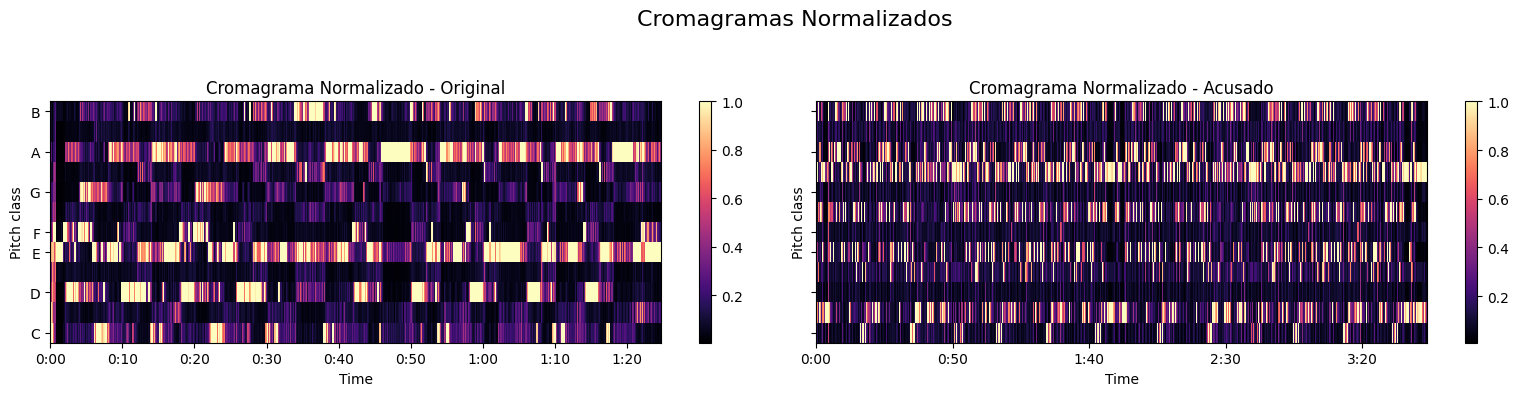

In [8]:
plot_cromagramas_lado_a_lado(
    chroma_orig_norm, chroma_acus_norm,
    sr_orig, sr_acus,
    title1='Cromagrama Normalizado - Original',
    title2='Cromagrama Normalizado - Acusado',
    suptitle='Cromagramas Normalizados'
)

## Analise de Melodia



### 1.Compressao Logaritmica - Sincronização

A compressão logarítmica ajuda a reduzir a variação de intensidade entre os vetores cromáticos antes de comparar

Redução de picos extremos, mais equilíbrio na visualização

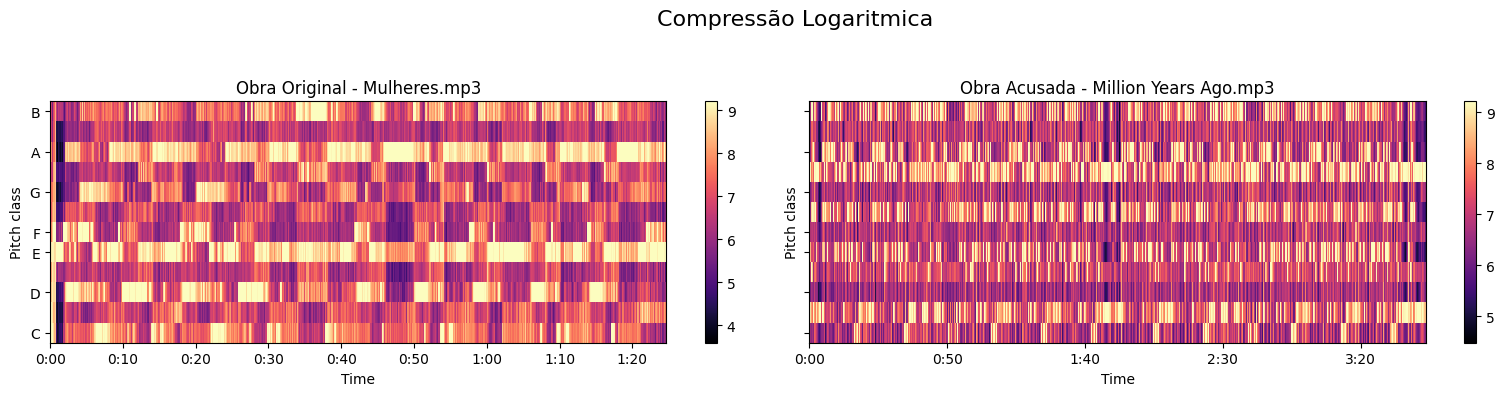

In [9]:
def log_compression(S, factor=10000):
    return np.log1p(factor * S)

chroma_orig_log = log_compression(chroma_orig_norm)
chroma_acus_log = log_compression(chroma_acus_norm)


plot_cromagramas_lado_a_lado(
    chroma_orig_log, chroma_acus_log,
    sr_orig, sr_acus,
    f'Obra Original - {file_original}',
    f'Obra Acusada - {file_acusado}',
    'Compressão Logaritmica'
)

### 2. Transposição para a tônica C - Sincronização

Transpor os cromagramas de ambas as músicas para que comecem na mesma tônica evita distorções na similaridade melódica



As “faixas” melódicas mudam de lugar, mas mantém a forma do contorno

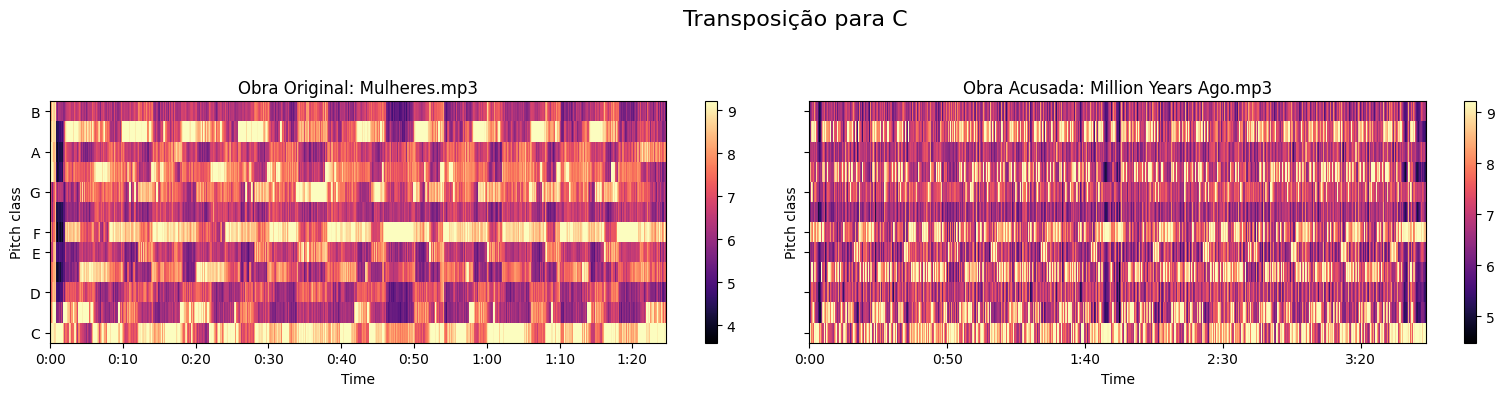

In [10]:
def transpose_to_C(chroma):
    mean_vector = chroma.mean(axis=1)
    shift = np.argmax(mean_vector)
    return np.roll(chroma, -shift, axis=0)

chroma_orig_transposed = transpose_to_C(chroma_orig_log)
chroma_acus_transposed = transpose_to_C(chroma_acus_log)

plot_cromagramas_lado_a_lado(
    chroma_orig_transposed, chroma_acus_transposed,
    sr_orig, sr_acus,
    f'Obra Original: {file_original}',
    f'Obra Acusada: {file_acusado}',
    'Transposição para C'
)


### 3.  Sincronização com DTW

Usar o Dynamic Time Warping com métrica de similaridade (cosseno) entre os cromagramas transpostos


Alinhamento visual, custo final e variação temporal

In [11]:
# normalizar: evitar que diferenças de volume influenciem
chroma_orig_transposed = librosa.util.normalize(chroma_orig.T).T
chroma_acus_transposed = librosa.util.normalize(chroma_acus.T).T


In [12]:
# reduzir dados
target_frames = 1000

chroma_orig_ds = resample(chroma_orig_transposed, target_frames, axis=1)
chroma_acus_ds = resample(chroma_acus_transposed, target_frames, axis=1)

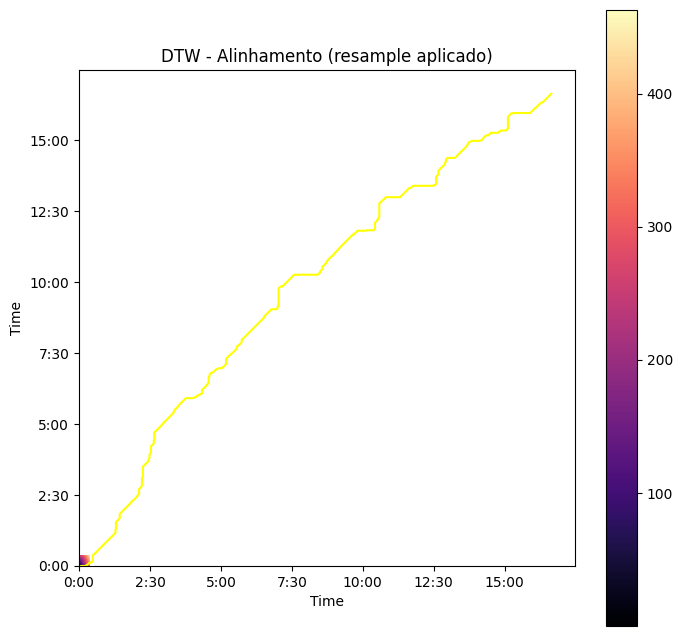

Distância DTW total: 0.14


In [13]:
# DTW com cosseno
D, wp = dtw(X=chroma_orig_ds, Y=chroma_acus_ds, metric='cosine')


plt.figure(figsize=(8, 8))
librosa.display.specshow(D, x_axis='time', y_axis='time')
plt.plot(wp[:, 1], wp[:, 0], color='yellow')
plt.title('DTW - Alinhamento (resample aplicado)')
plt.colorbar()
plt.show()


dist_total = D[wp[-1, 0], wp[-1, 1]]
print(f"Distância DTW total: {dist_total:.2f}")


Distância DTW parcial (100 frames): 0.1421856476852683


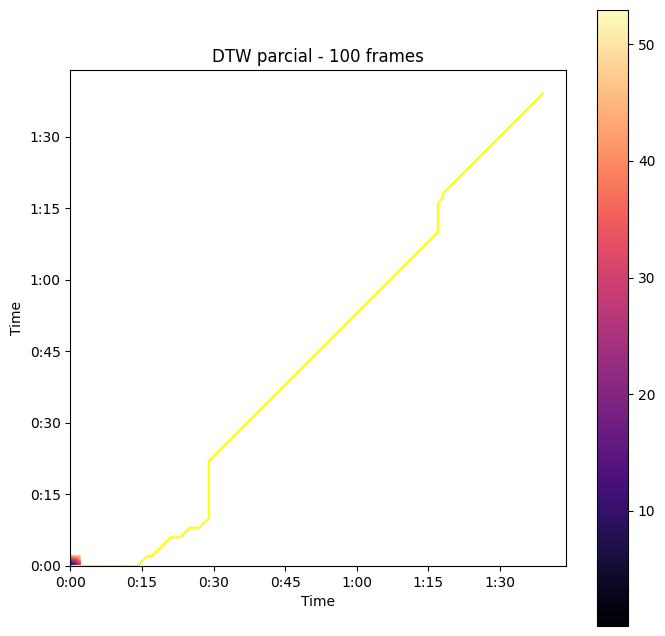

Distância DTW média (100 frames): 0.0012


In [14]:
D_test, wp_test = dtw(X=chroma_orig_ds[:, :100], Y=chroma_acus_ds[:, :100], metric='cosine')
print("Distância DTW parcial (100 frames):", D_test[wp_test[-1, 0], wp_test[-1, 1]])


plt.figure(figsize=(8, 8))
librosa.display.specshow(D_test, x_axis='time', y_axis='time')
plt.plot(wp_test[:, 1], wp_test[:, 0], color='yellow')
plt.title('DTW parcial - 100 frames')
plt.colorbar()
plt.show()


dist_parcial = D_test[wp_test[-1, 0], wp_test[-1, 1]]
#print(f"Distância DTW total: {dist_parcial:}")


dist_parcial_media = dist_parcial / len(wp_test)
print(f"Distância DTW média (100 frames): {dist_parcial_media:.4f}")


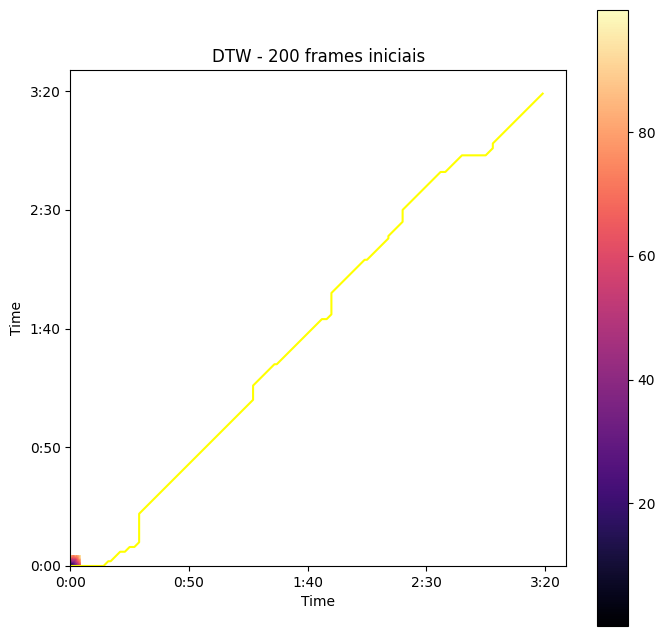

Distância DTW (200 frames): 0.1422


In [15]:
# ajuste o tamanho
segmento = 200  # ou 300, 500 etc.

D_seg, wp_seg = dtw(X=chroma_orig_ds[:, :segmento], Y=chroma_acus_ds[:, :segmento], metric='cosine')
plt.figure(figsize=(8, 8))
librosa.display.specshow(D_seg, x_axis='time', y_axis='time')
plt.plot(wp_seg[:, 1], wp_seg[:, 0], color='yellow')
plt.title(f'DTW - {segmento} frames iniciais')
plt.colorbar()
plt.show()

print(f"Distância DTW ({segmento} frames): {D_seg[wp_seg[-1, 0], wp_seg[-1, 1]]:.4f}")


# HARMONIA

Reconhecimento de Acordes e Análise Harmônica

### 1. Definição de Templates de Acordes

Representação simplificada de acordes maiores e menores (12 classes de pitch)
 * 1 = a presença forte da nota, 0 = ausência
 * Pode ser melhor usando pesos, mas fiz binario


- Ex: C = [1,0,0,0,1,0,0,1,0,0,0,0] (C, E, G)
- Db = [0,1,0,0,0,1,0,0,1,0,0,0] (Db, F, Ab)

In [16]:
# Templates acordes maiores
major_templates = {}
for i, root_note in enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']):
    template = np.zeros(12)
    # Fundamental
    template[i] = 1
    # Terça Maior (4 semitons acima)
    template[(i + 4) % 12] = 1
    # Quinta Justa (7 semitons acima)
    template[(i + 7) % 12] = 1
    major_templates[f'{root_note}maj'] = template

# Templates acordes menores
minor_templates = {}
for i, root_note in enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']):
    template = np.zeros(12)
    # Fundamental
    template[i] = 1
    # Terça Menor (3 semitons acima)
    template[(i + 3) % 12] = 1
    # Quinta Justa (7 semitons acima)
    template[(i + 7) % 12] = 1
    minor_templates[f'{root_note}min'] = template

all_chord_templates = {**major_templates, **minor_templates}

### 2. Reconhecimento de Acordes por Frame

In [17]:
def recognize_chords(chroma_features, chord_templates):
    recognized_chords = []

    for frame_idx in range(chroma_features.shape[1]):
        frame_vector = chroma_features[:, frame_idx]
        best_chord = None
        max_similarity = -1

        for chord_name, template_vector in chord_templates.items():

            similarity = 1 - cosine(librosa.util.normalize(frame_vector), librosa.util.normalize(template_vector))

            if similarity > max_similarity:
                max_similarity = similarity
                best_chord = chord_name
        recognized_chords.append(best_chord)
    return recognized_chords

In [18]:
# Reconhecer acordes
chords_orig = recognize_chords(chroma_orig_transposed, all_chord_templates)
chords_acus = recognize_chords(chroma_acus_transposed, all_chord_templates)

Reconhecendo acordes para a Obra Original...
Reconhecendo acordes para a Obra Acusada...


Reamostrar as sequencias de acordes para um numero gerenciavel de frames

mesmo target_frames que para o DTW para consistencia visual

Transformar a sequencia de strings de volta para uma representaçao numwrica que possa ser reamostrada, e depois converter de volta

In [19]:
# mapeamento numerico para os acordes para reamostrar
chord_to_int = {chord: i for i, chord in enumerate(all_chord_templates.keys())}
int_to_chord = {i: chord for chord, i in chord_to_int.items()}

chords_orig_numeric = np.array([chord_to_int.get(c, -1) for c in chords_orig]) # -1 para acordes n reconhecidos
chords_acus_numeric = np.array([chord_to_int.get(c, -1) for c in chords_acus])

In [20]:
# Reamostrar a representaçao numerica
# librosa.resample opera em um eixo, preciso sequencia numerica 'tempo'
chords_orig_ds_numeric = resample(chords_orig_numeric.astype(float), target_frames)
chords_acus_ds_numeric = resample(chords_acus_numeric.astype(float), target_frames)

In [21]:
# limitar o numero de acordes para nao sobrecarregar
display_limit = 50 # primeiros 50 acordes reconhecidos

print("\nPrimeiros acordes reconhecidos na Obra Original:")
print(chords_orig[:display_limit])
print("\nPrimeiros acordes reconhecidos na Obra Acusada:")
print(chords_acus[:display_limit])


Primeiros acordes reconhecidos na Obra Original:
['F#min', 'F#min', 'F#maj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amaj', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Amin', 'Cmin', 'Cmin', 'Cmin', 'Cmin', 'Cmin', 'Cmin', 'Cmin', 'Cmin', 'Cmaj', 'Cmaj', 'Cmaj', 'Cmaj', 'Cmaj', 'Cmaj', 'Cmaj', 'Cmaj', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin', 'Fmin']

Primeiros acordes reconhecidos na Obra Acusada:
['A#maj', 'A#min', 'A#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min', 'C#min']


### 3. Análise de Similaridade de Progressões com DTW em Sequências de Acordes

Para aplicar DTW diretamente em sequências de acordes (strings): função de custo customizada.

Calcular a distância de cosseno entre os templates de croma dos acordes reconhecidos

In [22]:
# Funçao de custo entre dois acordes usando seus templates de croma
def chord_distance(chord_name1, chord_name2, templates):
    if chord_name1 not in templates or chord_name2 not in templates:
        return 1.0

    template1 = librosa.util.normalize(templates[chord_name1])
    template2 = librosa.util.normalize(templates[chord_name2])

    # 0 = iguais, 1 = opostos
    return cosine(template1, template2)


--- Análise de Similaridade de Progressões Harmônicas (DTW em Acordes Reconhecidos - Downsampled 10x) ---


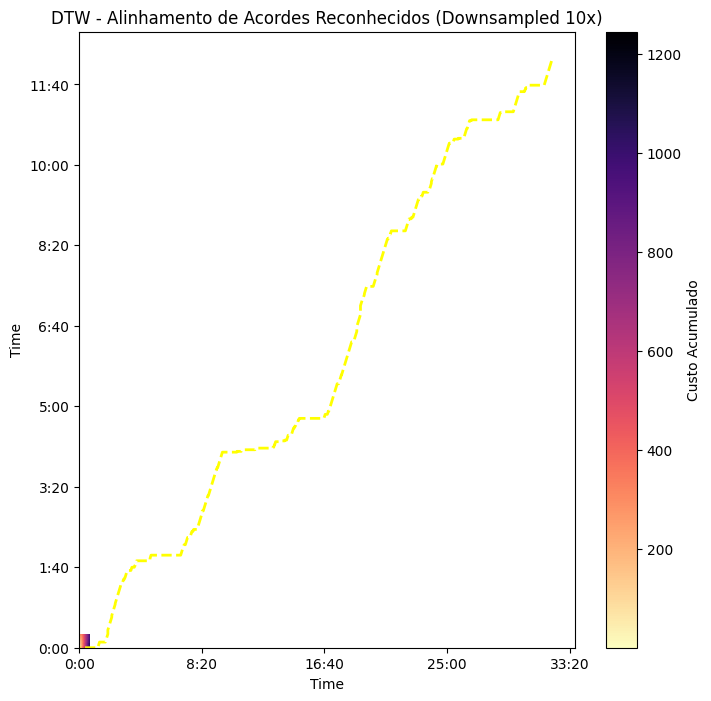

Distância DTW média (Acordes Reconhecidos): 0.0005


In [30]:
downsample_factor = 10 # Reduzir em 10x
chords_orig_ds_str = [chords_orig[i] for i in range(0, len(chords_orig), downsample_factor)]
chords_acus_ds_str = [chords_acus[i] for i in range(0, len(chords_acus), downsample_factor)]

print(f"\n--- Análise de Similaridade de Progressões Harmônicas (DTW em Acordes Reconhecidos - Downsampled {downsample_factor}x) ---")

cost_matrix = np.zeros((len(chords_orig_ds_str), len(chords_acus_ds_str)))
for i, c_orig in enumerate(chords_orig_ds_str):
    for j, c_acus in enumerate(chords_acus_ds_str):
        cost_matrix[i, j] = chord_distance(c_orig, c_acus, all_chord_templates)

# DTW na matriz de custo
D_chords, wp_chords = dtw(C=cost_matrix)

plt.figure(figsize=(8, 8))
librosa.display.specshow(D_chords, x_axis='time', y_axis='time', cmap='magma_r')
plt.plot(wp_chords[:, 1], wp_chords[:, 0], color='yellow', linestyle='--', linewidth=2)
plt.title(f'DTW - Alinhamento de Acordes Reconhecidos (Downsampled {downsample_factor}x)')
plt.colorbar(label='Custo Acumulado')
plt.show()

dist_total_chords = D_chords[wp_chords[-1, 0], wp_chords[-1, 1]]

dist_parcial_media_chords = dist_total_chords / len(wp_chords)
print(f"Distância DTW média (Acordes Reconhecidos): {dist_parcial_media_chords:.4f}")

### 4. Matrizes de Auto-Similaridade (SSM)

In [26]:
def plot_ssms_lado_a_lado(ssm_matrix1, title1, sr1, ssm_matrix2, title2, sr2, suptitle):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)
    fig.suptitle(suptitle, fontsize=16)


    img1 = librosa.display.specshow(ssm_matrix1, x_axis='time', y_axis='time', cmap='magma_r', ax=axs[0])
    axs[0].set_title(title1)
    fig.colorbar(img1, ax=axs[0], label='Similaridade')


    img2 = librosa.display.specshow(ssm_matrix2, x_axis='time', y_axis='time', cmap='magma_r', ax=axs[1])
    axs[1].set_title(title2)
    fig.colorbar(img2, ax=axs[1], label='Similaridade')

    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Ajusta layout para o suptitle
    plt.show()

In [27]:
# SSM para cromagramas transpostos
# A similaridade para a SSM é o dot product ou 1-cosine para distancia
# dot product = similaridade de cosseno
ssm_orig = chroma_orig_ds.T @ chroma_orig_ds
ssm_acus = chroma_acus_ds.T @ chroma_acus_ds

plot_ssms_lado_a_lado(
    ssm_orig, f'SSM Harmônica - {file_original}', sr_orig,
    ssm_acus, f'SSM Harmônica - {file_acusado}', sr_acus,
    'Matrizes de Auto-Similaridade Harmônica'
)

Output hidden; open in https://colab.research.google.com to view.

### --- 5. Matriz de Similaridade Cruzada (CSM) Harmônica ---

compara a Obra Original com a Obra Acusada para mostrar a similaridade entre seus frames

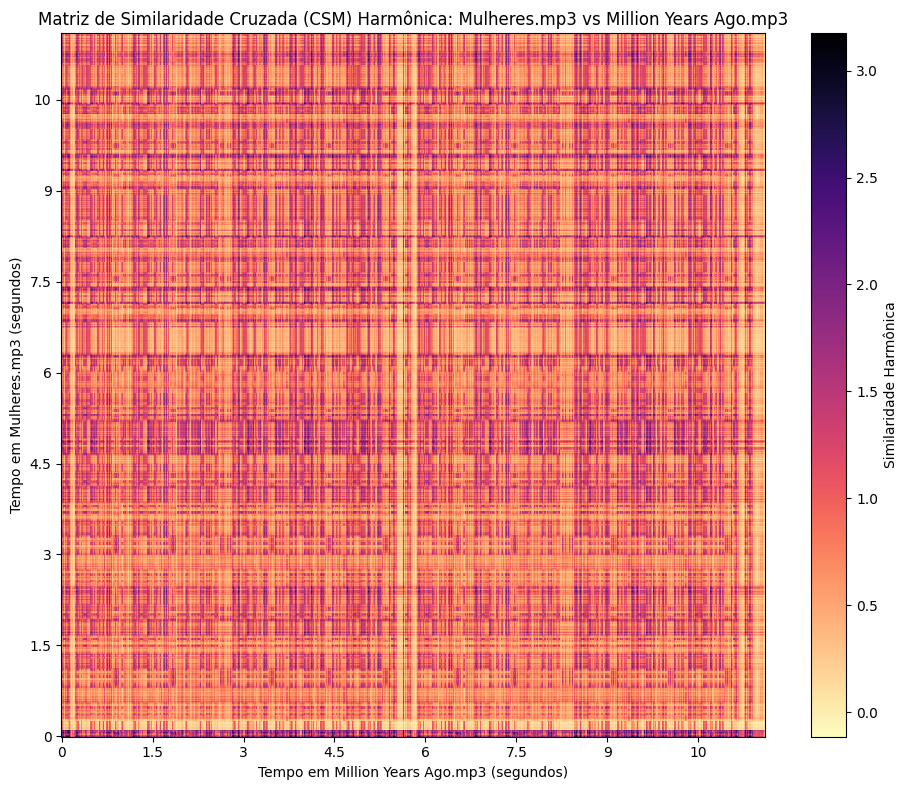

In [32]:
csm_harmonica = chroma_orig_ds.T @ chroma_acus_ds

plt.figure(figsize=(10, 8)) # Ajuste o tamanho da figura para melhor visualização
librosa.display.specshow(csm_harmonica, x_axis='time', y_axis='time', cmap='magma_r',
                         x_coords=librosa.frames_to_time(np.arange(csm_harmonica.shape[1]), sr=sr_acus), # Y = acusada
                         y_coords=librosa.frames_to_time(np.arange(csm_harmonica.shape[0]), sr=sr_orig)) # X = original
plt.title(f'Matriz de Similaridade Cruzada (CSM) Harmônica: {file_original} vs {file_acusado}')
plt.xlabel(f'Tempo em {file_acusado} (segundos)')
plt.ylabel(f'Tempo em {file_original} (segundos)')
plt.colorbar(label='Similaridade Harmônica')
plt.tight_layout()
plt.show()
